#Fake News Detection

In [ ]:
#import libraries

import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import cufflinks as cf
import plotly
import plotly.express as px
import seaborn as sns
import numpy as np
import io
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
#!pip install googletrans==4.0.0-rc1

In [ ]:
from IPython.core.display import HTML
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn import metrics,svm
from sklearn.metrics import accuracy_score, precision_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
import requests
from bs4 import BeautifulSoup
import ssl
from googletrans import Translator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
translator = Translator()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
cf.go_offline() #will make cufflinks offline
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
#read train csv using pandas
df = pd.read_csv(r'/content/train.csv')
#drop na values from dataframe
df = df.dropna()


In [ ]:
#Extract domain name from url
df['Fact_checked Article Domain'] = df['Fact-checked Article'].str.extract('//(?:\w+\.)?(.*?\..*?)/')

In [ ]:
#Example of google translate
example = 'Prezydent Meksyku nie sprzeciwia się szczepieniu dzieci na COVID-19'
result = translator.translate(example, dest='en')
print(result.text)
print(result.src)

The President of Mexico does not oppose the vaccination of children at Covid-19
pl


In [ ]:
#Create new column and assign nan as default value
df['Article_headline']=np.nan
#iterate through all rows of dataframe and web-scrape the title
for index, row in df.iterrows():
    url = row['Fact-checked Article']
    # making requests instance
    reqs = requests.get(url, verify = False)   
    # using the BeautifulSoup module
    soup = BeautifulSoup(reqs.text, 'html.parser')
    title = soup.find('title')  
    if title:     
      #translate the extracted title
      result = translator.translate(title.string, dest='en')
      df.loc[index, 'Article_headline'] = result.text

In [ ]:
#print rows where article headline was not extracted
selected_rows = df[~df['Article_headline'].isnull()]
print(selected_rows.shape)

(19, 8)


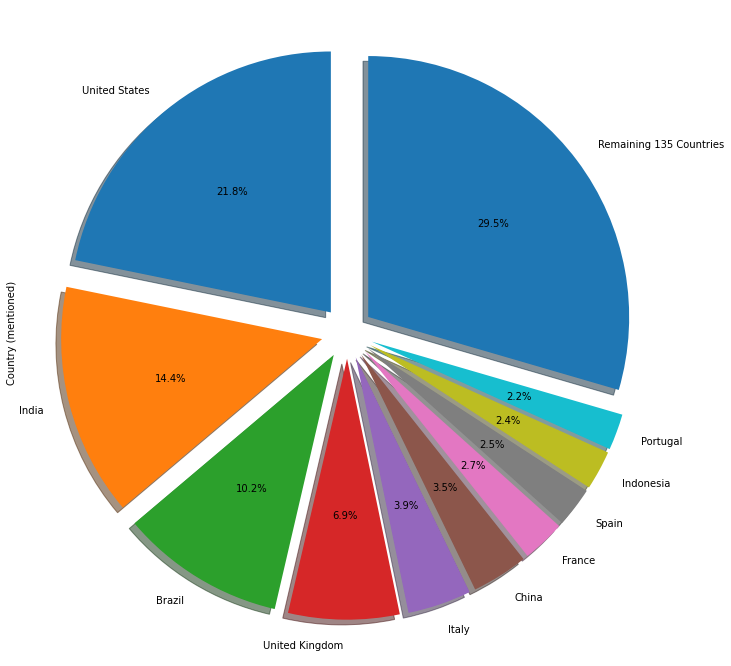

In [ ]:
#Pie chart for top 10 countries mentioned 
explode = [0.1]*11
temp = df['Country (mentioned)'].value_counts()
temp2 = temp.head(10)
if len(temp) > 10:
    temp2['Remaining {0} Countries'.format(len(temp) - 10)] = sum(temp[10:])
temp2.plot.pie(figsize = (12,12), startangle = 90, legend = False, autopct='%1.1f%%', explode=explode, shadow=True,)

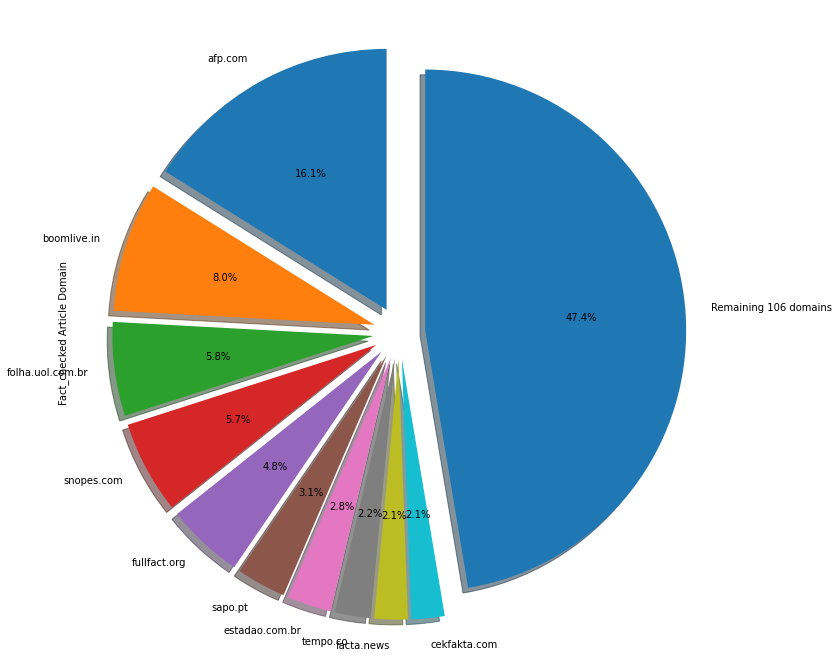

In [ ]:
#Pie chart for top 10 article domains
explode = [0.1]*11
temp = df['Fact_checked Article Domain'].value_counts()
temp2 = temp.head(10)
if len(temp) > 10:
    temp2['Remaining {0} domains'.format(len(temp) - 10)] = sum(temp[10:])
temp2.plot.pie(figsize = (12,12), startangle = 90, legend = False, autopct='%1.1f%%', explode=explode, shadow=True,)

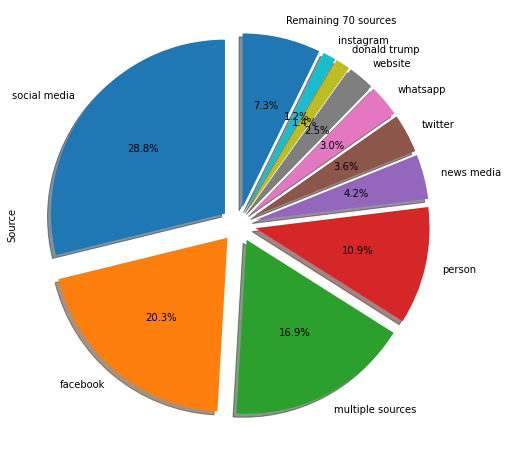

In [ ]:
#Pie chart for top 10 sources
explode = [0.1]*11
temp = df['Source'].value_counts()
temp2 = temp.head(10)
if len(temp) > 10:
    temp2['Remaining {0} sources'.format(len(temp) - 10)] = sum(temp[10:])
temp2.plot.pie(figsize = (8,8), startangle = 90, legend = False, autopct='%1.1f%%', explode=explode, shadow=True,)

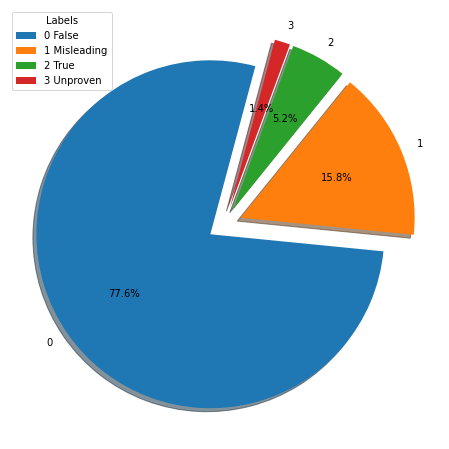

In [ ]:
#Pie chart with Label distribution
df['Label'].value_counts().plot.pie(figsize = (8,8), startangle = 75, legend = True, autopct='%1.1f%%', explode=(0.1,0.1,0.1,0.1), shadow=True,)
plt.axis('off')
plt.legend(['0 False', '1 Misleading', '2 True', '3 Unproven'],loc='upper left', title='Labels')
plt.show()

Text(0.5, 1.0, 'Bar graph of Source x Labels')

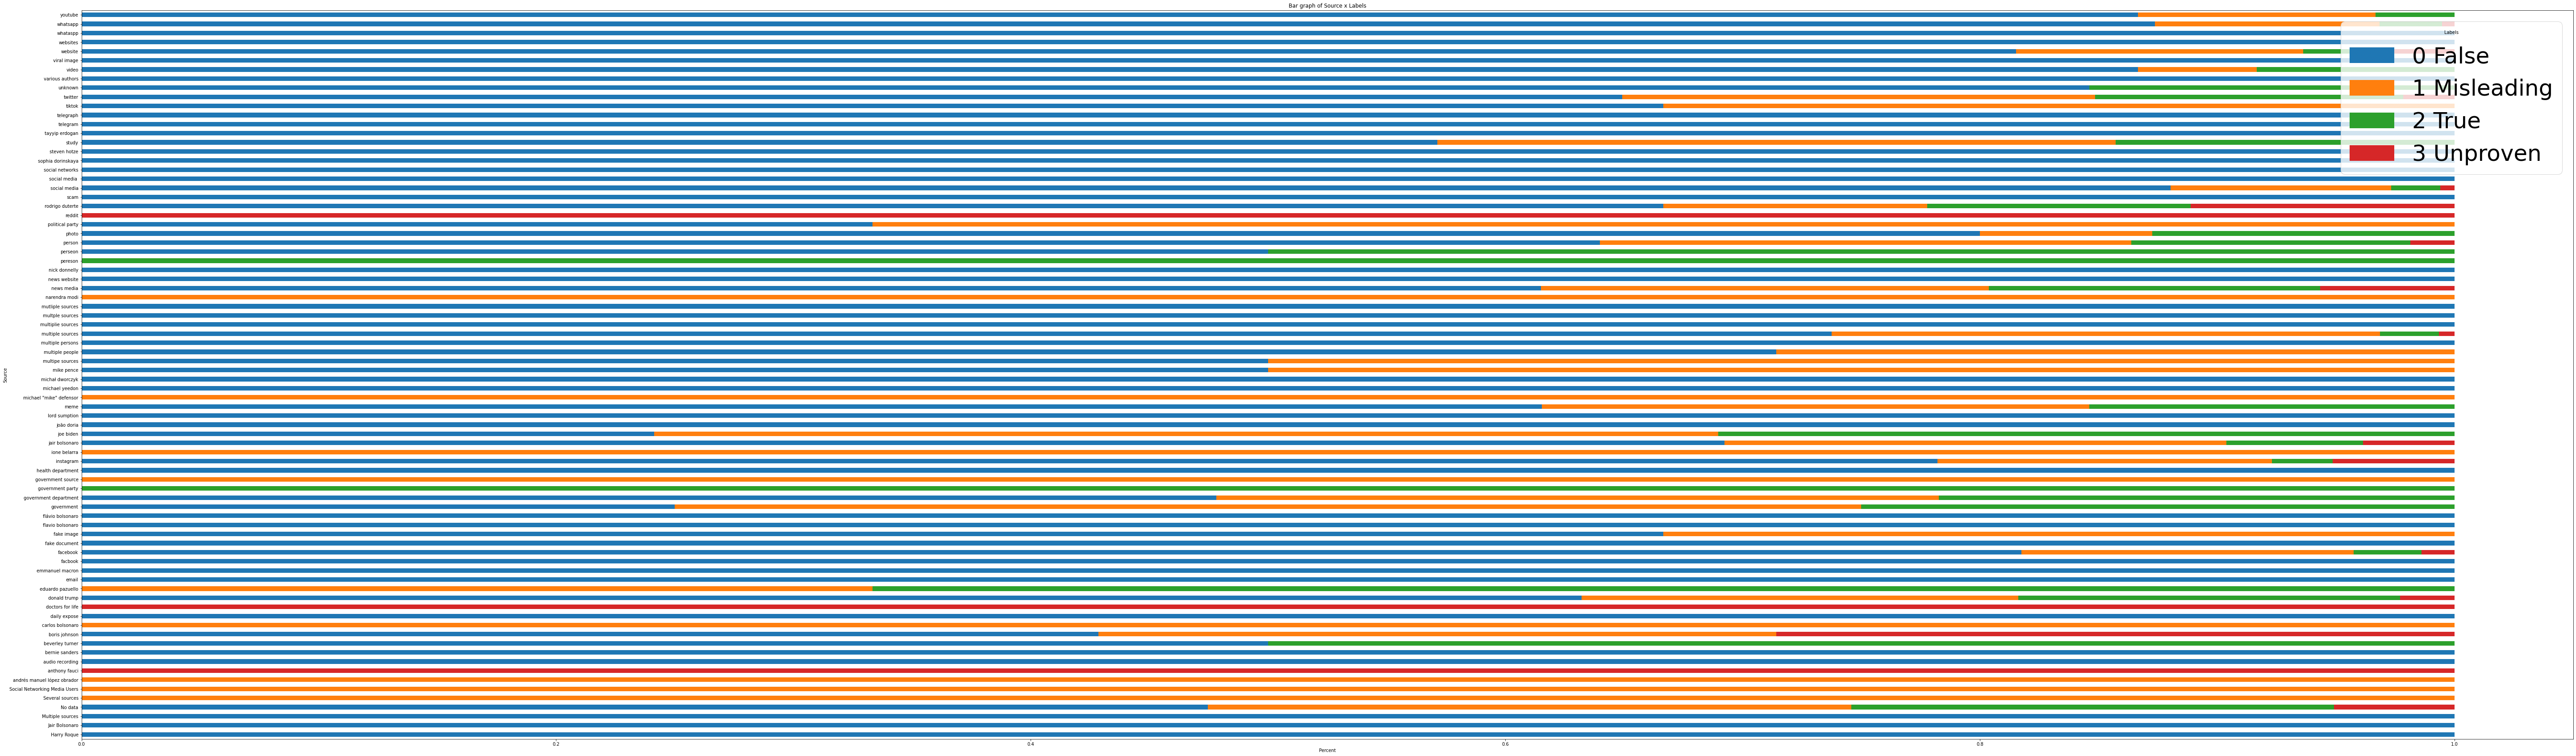

In [ ]:
fig, ax = plt.subplots(figsize=(100,30))

# prepare dataframe for plotting
dfp = pd.crosstab(index=df['Source'], columns=df["Label"]).apply(lambda r: r/r.sum(), axis=1)

# simple stacked plot for Labels and sources
ax = dfp.plot(kind="barh", stacked=True, ax=ax)
ax.legend(['0 False', '1 Misleading', '2 True', '3 Unproven'], loc='upper right', title='Labels',fontsize=50)
ax.set_xlabel("Percent")
ax.set_title("Bar graph of Source x Labels")

In [ ]:
#Store list of sources that gave respective information

source_real=[]
source_fake=[]
source_misleading=[]
source_unproven=[]

df_sources = df[['Source','Fact-checked Article','Label']]

for i,row in df_sources.iterrows():
    val = row['Source']
    if row['Label'] == 0:
        source_fake.append(val)
    elif row['Label'] == 1:
        source_misleading.append(val)
    elif row['Label'] == 2:
        source_real.append(val)
    elif row['Label'] == 3:
        source_unproven.append(val)

In [ ]:
uniqueValues_real = list(OrderedDict.fromkeys(source_real)) 
print("Sources for real news:",uniqueValues_real)

Sources for real news: ['joe biden', 'news media', 'person', 'twitter', 'social media', 'multiple sources', 'facebook', 'government department', 'instagram', 'jair bolsonaro', 'beverley turner', 'No data', 'website', 'government party', 'pereson', 'eduardo pazuello', 'perseon', 'whatsapp', 'donald trump', 'youtube', 'government', 'unknown', 'meme', 'rodrigo duterte', 'video', 'photo', 'study']


In [ ]:
uniqueValues_fake = list(OrderedDict.fromkeys(source_fake)) 
print("Sources for real news:",uniqueValues_fake)

Sources for real news: ['person', 'website', 'multiple people', 'No data', 'facebook', 'multiple sources', 'social media', 'news media', 'instagram', 'multiple persons', 'whatsapp', 'twitter', 'telegram', 'mutliple sources', 'facbook', 'Multiple sources', 'tiktok', 'government department', 'emmanuel macron', 'lord sumption', 'jair bolsonaro', 'daily expose', 'sophia dorinskaya', 'michael yeedon', 'tayyip erdogan', 'websites', 'nick donnelly', 'perseon', 'beverley turner', 'michał dworczyk', 'social networks', 'multple sources', 'health department', 'various authors', 'whataspp', 'youtube', 'news website', 'multipe sources', 'joe biden', 'rodrigo duterte', 'steven hotze', 'telegraph', 'multiplie sources', 'donald trump', 'Harry Roque', 'flavio bolsonaro', 'flávio bolsonaro', 'joão doria', 'bernie sanders', 'Jair Bolsonaro', 'photo', 'video', 'study', 'unknown', 'social media ', 'mike pence', 'boris johnson', 'viral image', 'government', 'scam', 'political party', 'meme', 'audio recordin

In [ ]:
uniqueValues_misleading = list(OrderedDict.fromkeys(source_misleading)) 
print("Sources for misleading news:",uniqueValues_misleading)

Sources for misleading news: ['multiple sources', 'social media', 'government department', 'twitter', 'Social Networking Media Users', 'Several sources', 'facebook', 'person', 'tiktok', 'news media', 'instagram', 'website', 'No data', 'multiple people', 'joe biden', 'andrés manuel lópez obrador', 'ione belarra', 'jair bolsonaro', 'narendra modi', 'government source', 'multipe sources', 'whatsapp', 'carlos bolsonaro', 'rodrigo duterte', 'michael "mike" defensor', 'eduardo pazuello', 'youtube', 'donald trump', 'political party', 'mike pence', 'study', 'government', 'boris johnson', 'fake image', 'meme', 'photo', 'video']


In [ ]:
uniqueValues_unproven = list(OrderedDict.fromkeys(source_unproven)) 
print("Sources for unproven news:",uniqueValues_unproven)

Sources for unproven news: ['website', 'news media', 'facebook', 'instagram', 'social media', 'twitter', 'person', 'jair bolsonaro', 'anthony fauci', 'No data', 'whatsapp', 'multiple sources', 'doctors for life', 'rodrigo duterte', 'reddit', 'donald trump', 'boris johnson']


In [ ]:
#Store set of the list
real_set = set(uniqueValues_real) 
fake_set = set(uniqueValues_fake) 
misleading_set = set(uniqueValues_misleading)
unproven_set = set(uniqueValues_unproven)

print("Sources for all types of news:",real_set & fake_set & misleading_set & unproven_set)
print("Sources for fake, misleading and unproven news:",fake_set & misleading_set & unproven_set)

Sources for all types of news: {'facebook', 'whatsapp', 'multiple sources', 'jair bolsonaro', 'person', 'twitter', 'social media', 'donald trump', 'instagram', 'news media', 'rodrigo duterte', 'website', 'No data'}
Sources for fake, misleading and unproven news: {'facebook', 'whatsapp', 'multiple sources', 'jair bolsonaro', 'No data', 'person', 'twitter', 'social media', 'donald trump', 'instagram', 'news media', 'rodrigo duterte', 'website', 'boris johnson'}


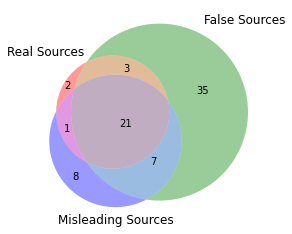

In [ ]:
#Draw venn diagram
import matplotlib_venn as venn
venn.venn3([real_set,fake_set,misleading_set],
       set_labels=('Real Sources', 'False Sources','Misleading Sources'))
plt.show()

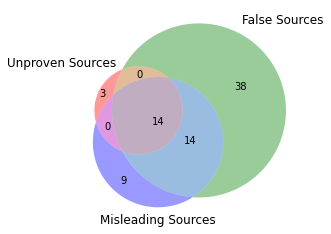

In [ ]:
#Draw venn diagram
import matplotlib_venn as venn
venn.venn3([unproven_set,fake_set,misleading_set],
       set_labels=('Unproven Sources', 'False Sources','Misleading Sources')
     )
plt.show()

In [ ]:
#function to get top n common words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#function to get top n bigrams 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#function to get top n trigrams 
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

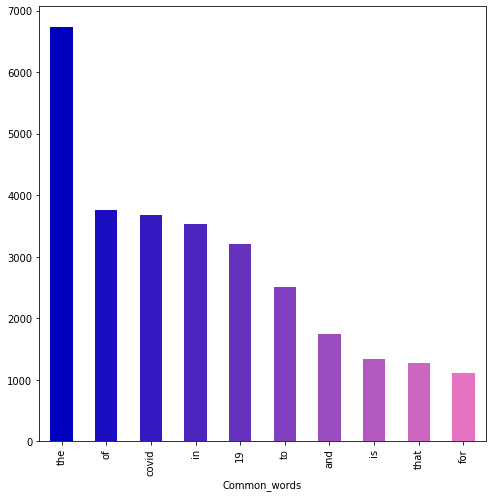

In [ ]:
common_words_wosw = get_top_n_words(df['Claim'])
df_common_words_wosw = pd.DataFrame(common_words_wosw, columns=['Common_words', "Count"])
df_common_words_wosw = df_common_words_wosw.head(10)
my_colors = [(x/10.0, x/20.0, 0.75) for x in range(len(df_common_words_wosw))]
df_common_words_wosw.plot.bar(x='Common_words',y='Count',figsize = (8,8),color=my_colors,legend=False)

In [ ]:
#Remove stopwords from Claim
df = df.apply(lambda x: x.astype(str).str.lower())
df['Claim_without_stopwords'] = df['Claim'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
print(df['Claim_without_stopwords'])

0       video circulating internet claiming masks used...
1       vice president kamala harris "admits" covid va...
2              us withhold benefits unvaccinated veterans
3       u.s. president joe biden said covid-19 vaccine...
4       customers required provide id proof covid-19 v...
                              ...                        
6379    kazakhstan rasprostranyayushih 0 information c...
6380    2020 u.s. presidential election could postpone...
6381    united states "refused" covid-19 diagnostic te...
6382    bolsonaro says coronavirus hysteria benefits c...
6383                  china celebrates elimination corona
Name: Claim_without_stopwords, Length: 6384, dtype: object


In [ ]:
common_words = get_top_n_words(df['Claim_without_stopwords'])
df_common_words = pd.DataFrame(common_words, columns=['Common_words', "Count"])

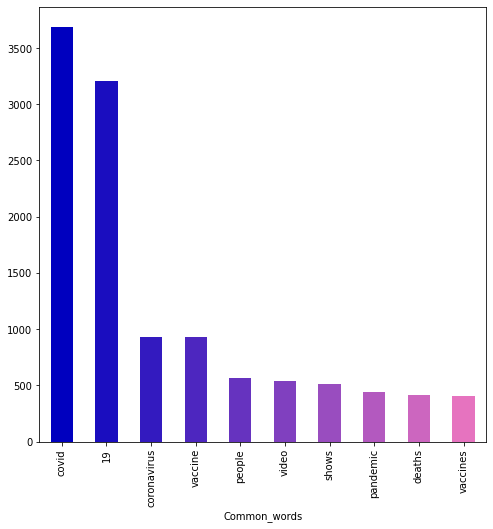

In [ ]:
#Draw bar graph with common words
from itertools import cycle, islice
df_common_words = df_common_words.head(10)
my_colors = [(x/10.0, x/20.0, 0.75) for x in range(len(df_common_words))]
df_common_words.plot.bar(x='Common_words',y='Count',figsize = (8,8),color=my_colors,legend=False)

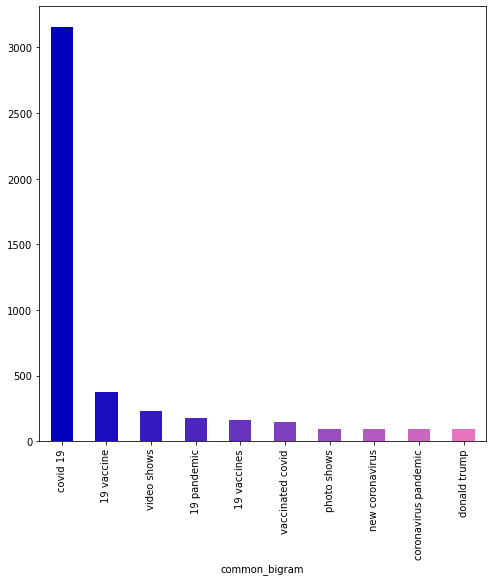

In [ ]:
#Draw bar graph with bigrams
common_bigram = get_top_n_bigram(df['Claim_without_stopwords'])
df_common_bigram = pd.DataFrame(common_bigram, columns=['common_bigram', "Count"])
df_common_bigram  = df_common_bigram.head(10)
df_common_bigram.plot.bar(x='common_bigram',y='Count',figsize = (8,8),color=my_colors,legend=False)

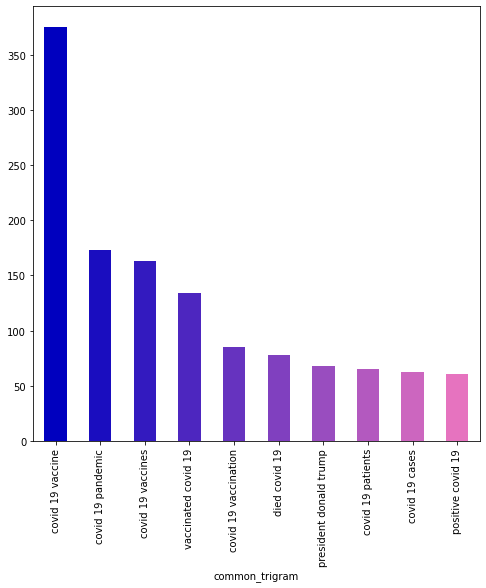

In [ ]:
#Draw bar graph with trigrams
common_trigram = get_top_n_trigram(df['Claim_without_stopwords'])
df_common_trigram = pd.DataFrame(common_trigram, columns=['common_trigram', "Count"])
df_common_trigram  = df_common_trigram.head(10)
df_common_trigram.plot.bar(x='common_trigram',y='Count',figsize = (8,8),color=my_colors,legend=False)

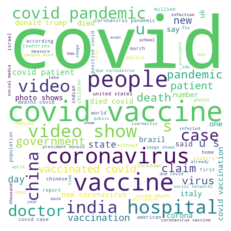

<Figure size 2880x2880 with 0 Axes>

In [ ]:
#generate word cloud with combined text
wc = WordCloud(background_color="white", max_words=100,
               max_font_size=256,
               random_state=42, width=500, height=500)
wc.generate(' '.join(df['Claim_without_stopwords']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.margins(x=0, y=0)
plt.figure(figsize=(40,40))
plt.show()

In [ ]:
#Label Encoder for columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train = df
df_train = df_train.drop(labels = ['Review Date', 'Claim','Fact-checked Article'],axis=1)
encoded_workclass = le.fit_transform(df_train['Country (mentioned)'])
df_train['Country (mentioned)']=encoded_workclass
encoded_workclass = le.fit_transform(df_train['Source'])
df_train['Source']=encoded_workclass
encoded_workclass = le.fit_transform(df_train['Fact_checked Article Domain'])
df_train['Fact_checked Article Domain']=encoded_workclass


In [ ]:
#Combine claim and extract article headline
df_train['Article_headline_without_stopwords'] = df_train['Article_headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_train['text']=df_train['Claim_without_stopwords'].astype(str) +" "+df_train['Article_headline_without_stopwords'].astype(str)

In [ ]:
df_train = df_train.sample(frac=1)

In [ ]:
#combine all the columns to a single column
y = df_train.Label
x = df_train.loc[:,['Country (mentioned)','Source','Fact_checked Article Domain','text']]
x['combined'] = x['Country (mentioned)'].astype(str) +" "+ x['Source'].astype(str) +" "+x['Fact_checked Article Domain'].astype(str) +" "+x['text'].astype(str) 
x = x.drop(['Country (mentioned)','Source','Fact_checked Article Domain','text'],axis=1)
x = x.combined

In [ ]:
#Split dataset for train and test 80-20
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20)
tfidf_vect = TfidfVectorizer(stop_words = 'english')
tfidf_train = tfidf_vect.fit_transform(x_train)
tfidf_test = tfidf_vect.transform(x_test)
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vect.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
print(tfidf_df.iloc[:,-5:-2])

      zoo  zookeepers  zum
0     0.0         0.0  0.0
1     0.0         0.0  0.0
2     0.0         0.0  0.0
3     0.0         0.0  0.0
4     0.0         0.0  0.0
...   ...         ...  ...
5102  0.0         0.0  0.0
5103  0.0         0.0  0.0
5104  0.0         0.0  0.0
5105  0.0         0.0  0.0
5106  0.0         0.0  0.0

[5107 rows x 3 columns]


Accuracy: 0.772
Precision: 0.772
F1 Score: 0.772


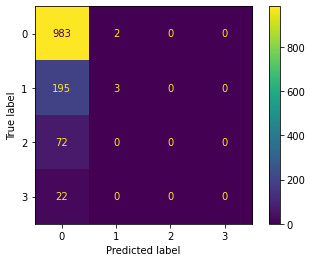

In [ ]:
#Create a svm Classifier
clf = svm.SVC() 
#Train the model using the training sets
clf.fit(tfidf_train, y_train)
#Predict the response for test dataset
y_pred_SVM = clf.predict(tfidf_test)
# Model Evaluation Metrics
print('Accuracy: %.3f' % metrics.accuracy_score(y_test, y_pred_SVM))
print('Precision: %.3f' % precision_score(y_test, y_pred_SVM, average='micro'))
print('F1 Score: %.3f' % f1_score(y_test, y_pred_SVM, average='micro'))
#print confusion matrix
ConfusionMatrixDisplay.from_estimator(clf, tfidf_test, y_test)


Accuracy: 0.771
Precision: 0.771
F1 Score: 0.771


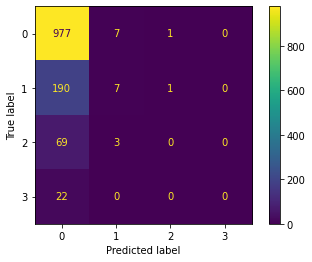

In [ ]:
#Logistic Regression 
LR = LogisticRegression()
LR.fit(tfidf_train, y_train)
y_pred_LR = LR.predict(tfidf_test)
LRscore = metrics.accuracy_score(y_test,y_pred_LR)
print("Accuracy: %0.3f" %LRscore)
print('Precision: %.3f' % precision_score(y_test, y_pred_LR, average='micro'))
print('F1 Score: %.3f' % f1_score(y_test, y_pred_LR, average='micro'))
ConfusionMatrixDisplay.from_estimator(LR, tfidf_test, y_test)

accuracy: 0.745
Precision: 0.745
F1 Score: 0.745


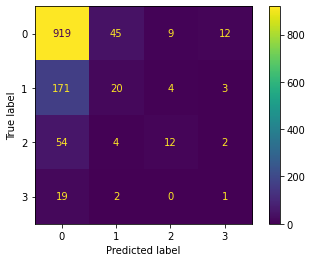

In [ ]:
#adaptive Booster Classifier
Adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=5,random_state=1)
Adab.fit(tfidf_train, y_train)
y_pred_ADAB = Adab.predict(tfidf_test)
ABscore = metrics.accuracy_score(y_test,y_pred_ADAB)
print("accuracy: %0.3f" %ABscore)
print('Precision: %.3f' % precision_score(y_test, y_pred_ADAB, average='micro'))
print('F1 Score: %.3f' % f1_score(y_test, y_pred_ADAB, average='micro'))
ConfusionMatrixDisplay.from_estimator(Adab, tfidf_test, y_test)

accuracy:  0.774
Precision: 0.774
F1 Score: 0.774


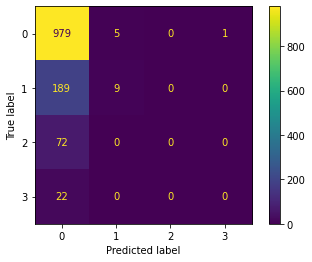

In [ ]:
#Random Forest Classifier
Rando = RandomForestClassifier(n_estimators=100,random_state=0)
Rando.fit(tfidf_train,y_train)
y_pred_Rando = Rando.predict(tfidf_test)
RFscore = metrics.accuracy_score(y_test,y_pred_Rando)
print("accuracy:  %0.3f" %RFscore)
print('Precision: %.3f' % precision_score(y_test, y_pred_Rando, average='micro'))
print('F1 Score: %.3f' % f1_score(y_test, y_pred_Rando, average='micro'))
ConfusionMatrixDisplay.from_estimator(Rando, tfidf_test, y_test)

In [ ]:
#Read test csv file
df_test = pd.read_csv(r'/content/test.csv')

In [ ]:
#Remove stopwords
df_test['Claim_without_stopwords'] = df_test['Claim'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
print(df_test['Claim_without_stopwords'])

0                Israel discovered vaccine corona virus.
1      Cristiano Ronaldos hotels turned hospitals tre...
2      Preta Gil Coronavirus. Dragged 300,000 people ...
3      Example - closing schools 30 cases identified ...
4      No, Germany coronavirus put 22 times money Ita...
                             ...                        
705    Gen. David Berger said Marines comply COVID-19...
706    15-year-old boy passes away heart attack two d...
707    â€œChris Christie ICU reported put ventilator.â€
708    Christian Eriksen's collapse due coronavirus v...
709    Christian Eriksen's collapse due coronavirus v...
Name: Claim_without_stopwords, Length: 710, dtype: object


In [ ]:
#Extract domain
df_test['Fact_checked Article Domain'] = df['Fact-checked Article'].str.extract('//(?:\w+\.)?(.*?\..*?)/')

In [ ]:
df['Article_headline']=np.nan
#iterate through all rows of dataframe and web-scrape the title
for index, row in df.iterrows():
    url = row['Fact-checked Article']
    # making requests instance
    reqs = requests.get(url, verify = False)   
    # using the BeautifulSoup module
    soup = BeautifulSoup(reqs.text, 'html.parser')
    title = soup.find('title')  
    if title:     
      #translate the extracted title
      result = translator.translate(title.string, dest='en')
      df.loc[index, 'Article_headline'] = result.text

In [ ]:
#Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_test = df_test.drop(labels = ['Review Date', 'Claim','Fact-checked Article'],axis=1)
encoded_workclass = le.fit_transform(df_test['Country (mentioned)'])
df_test['Country (mentioned)']=encoded_workclass
encoded_workclass = le.fit_transform(df_test['Source'])
df_test['Source']=encoded_workclass
encoded_workclass = le.fit_transform(df_test['Fact_checked Article Domain'])
df_test['Fact_checked Article Domain']=encoded_workclass

In [ ]:
#Combine claim and extract article headline 
df_test['text']=df_test['Claim_without_stopwords'].astype(str) 

In [ ]:
#combine all columns and drop columns that are not required
x = df_test.loc[:,['Country (mentioned)','Source','Fact_checked Article Domain','text']]
x['combined'] = x['Country (mentioned)'].astype(str) +" "+ x['Source'].astype(str) +" "+x['Fact_checked Article Domain'].astype(str) +" "+x['text'].astype(str) 
x = x.drop(['Country (mentioned)','Source','Fact_checked Article Domain','text'],axis=1)
x = x.combined

In [ ]:
#transform test data to tf-idf
tfidf_test = tfidf_vect.transform(x)

In [ ]:
#predict on fitted data
y_pred_LR= LR.predict(tfidf_test)
y_pred_rando = Rando.predict(tfidf_test)
y_pred_ADAB = Adab.predict(tfidf_test)
y_pred_SVM = clf.predict(tfidf_test)

In [ ]:
#convert to dataframe
y = pd.DataFrame(y_pred_LR)

In [ ]:
#Convert to csv for submission
y.columns = ['Category']

y.index.name = 'Id'
y.index += 1

y.to_csv('Team12_S8.csv',)